# **`flygym`-MuJoCo exercise: CPG controller** 

<a target="_blank" href="https://colab.research.google.com/github/NeLy-EPFL/flygym/blob/main/notebooks/mujoco_CPG_control.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**NOTE: You need to select a GPU instance on Google Colab for this notebook. Go to "Runtime" > "Change runtime type", select "GPU" under "Hardware accelerator" and click "Save."**

See [GitHub repo](https://github.com/NeLy-EPFL/flygym) for code and [documentation here](https://nely-epfl.github.io/flygym/).


In [22]:
import PIL.Image

import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from tqdm import trange
from flygym.util.config import all_leg_dofs
from flygym.state import stretched_pose

import cv2

from flygym.util.cpg_controller import (advancement_transfer, phase_oscillator, sine_output, initialize_solver,
                         phase_biases_tripod_measured, phase_biases_tripod_idealized,
                         phase_biases_ltetrapod_idealized, phase_biases_metachronal_idealized,
                         plot_phase_amp_output)

In [23]:
# Initialize the simulation
run_time = 1
enable_adhesion = True

sim_params = MuJoCoParameters(
    timestep=2e-4,
    render_mode="headless",
    render_playspeed=0.05,
    enable_adhesion=enable_adhesion,
    draw_adhesion=enable_adhesion,
    adhesion_gain=20,
    draw_contacts=True,
)
nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
    spawn_pos=[0.0, 0.0, 0.5],
)

num_steps_base = int(run_time / nmf.timestep)

In [24]:
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
with open(data_path / 'behavior' / 'single_steps.pkl', 'rb') as f:
    data = pickle.load(f)

In [25]:
# Interpolate 5x
step_duration = len(data['joint_LFCoxa'])
interp_step_duration = int(step_duration * data['meta']['timestep'] / nmf.timestep)
data_block = np.zeros((len(nmf.actuated_joints), interp_step_duration))
measure_t = np.arange(step_duration) * data['meta']['timestep']
interp_t = np.arange(interp_step_duration) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

In [26]:
legs = ["RF", "RM", "RH", "LF", "LM", "LH"]
n_oscillators = len(legs)

t = np.arange(0, run_time, nmf.timestep)

n_joints = len(nmf.actuated_joints)
leg_ids = np.arange(len(legs)).astype(int)
joint_ids = np.arange(n_joints).astype(int)
# Map the id of the joint to the leg it belongs to (usefull to go through the steps for each legs)
match_leg_to_joints = np.array([i  for joint in nmf.actuated_joints for i, leg in enumerate(legs) if leg in joint])

In [27]:
# lets say we want 10 oscillations in the time period
n_steps = 12
frequencies = np.ones(n_oscillators) * n_steps / run_time

# For now each oscillator have the same amplitude
target_amplitudes = np.ones(n_oscillators) * 1.0
rates = np.ones(n_oscillators) * 20.0

phase_biases = phase_biases_tripod_idealized * 2 * np.pi
coupling_weights = (np.abs(phase_biases) > 0).astype(float) * 10.0 

# Simulation

In [28]:
n_stabilisation_steps = 2000
num_steps = n_stabilisation_steps + num_steps_base

# Initilize the simulation
np.random.seed(42)
start_ampl = np.ones(6)*0.2
obs, info = nmf.reset()
solver = initialize_solver(phase_oscillator, "dopri5", nmf.curr_time,
                            n_oscillators, frequencies,
                              coupling_weights, phase_biases,
                                start_ampl, rates,
                                int_params={"atol": 1e-6, "rtol": 1e-6, "max_step":100000})


# Initalize storage
obs_list_spawn_zero = []
phases_spawn_zero = np.zeros((num_steps, n_oscillators))
amplitudes_spawn_zero = np.zeros((num_steps, n_oscillators))

joint_angles = np.zeros((num_steps, n_joints))
input_joint_angles = np.zeros(len(nmf.actuated_joints))

for i in trange(num_steps):

    res = solver.integrate(nmf.curr_time)
    phase = res[:n_oscillators]
    amp = res[n_oscillators:2*n_oscillators]

    phases_spawn_zero[i, :] = phase
    amplitudes_spawn_zero[i, :] = amp    

    if i == n_stabilisation_steps:
        # Now set the amplitude to their real values
        solver.set_f_params(n_oscillators, frequencies,
                              coupling_weights, phase_biases,
                                target_amplitudes, rates)
    if i > n_stabilisation_steps:
        indices = advancement_transfer(phase, interp_step_duration, match_leg_to_joints)
        # scale amplitude by interpolating between the resting values and i timestep value
        input_joint_angles = data_block[joint_ids, 0] + \
                  (data_block[joint_ids, indices]-data_block[joint_ids, 0])*amp[match_leg_to_joints]
    else:
        input_joint_angles = data_block[joint_ids, 0]

    joint_angles[i, :] = input_joint_angles
    adhesion_signal = nmf.get_adhesion_vector()
 

    action = {"joints": input_joint_angles, "adhesion": adhesion_signal}
    
    obs, reward, terminated, truncated, info = nmf.step(action)
    obs_list_spawn_zero.append(obs)
    render_status = nmf.render()


100%|██████████| 6000/6000 [00:19<00:00, 300.46it/s]


In [29]:
dist_zero = obs_list_spawn_zero[-1]["fly"][0] - obs_list_spawn_zero[0]["fly"][0]
dist_zero

array([ 6.91855168,  0.87353236, -0.81381458])

In [30]:
nmf = nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
    spawn_pos=[1e-12, 0.0, 0.5],
)


n_stabilisation_steps = 2000
num_steps = n_stabilisation_steps + num_steps_base

# Initilize the simulation
np.random.seed(42)
start_ampl = np.ones(6)*0.2
obs, info = nmf.reset()
solver = initialize_solver(phase_oscillator, "dopri5", nmf.curr_time,
                            n_oscillators, frequencies,
                              coupling_weights, phase_biases,
                                start_ampl, rates,
                                int_params={"atol": 1e-6, "rtol": 1e-6, "max_step":100000})


# Initalize storage
obs_list_spawn_one = []
phases_spawn_one = np.zeros((num_steps, n_oscillators))
amplitudes_spawn_one = np.zeros((num_steps, n_oscillators))

joint_angles = np.zeros((num_steps, n_joints))
input_joint_angles = np.zeros(len(nmf.actuated_joints))

for i in trange(num_steps):

    res = solver.integrate(nmf.curr_time)
    phase = res[:n_oscillators]
    amp = res[n_oscillators:2*n_oscillators]

    phases_spawn_one[i, :] = phase
    amplitudes_spawn_one[i, :] = amp    

    if i == n_stabilisation_steps:
        # Now set the amplitude to their real values
        solver.set_f_params(n_oscillators, frequencies,
                              coupling_weights, phase_biases,
                                target_amplitudes, rates)
    if i > n_stabilisation_steps:
        indices = advancement_transfer(phase, interp_step_duration, match_leg_to_joints)
        # scale amplitude by interpolating between the resting values and i timestep value
        input_joint_angles = data_block[joint_ids, 0] + \
                  (data_block[joint_ids, indices]-data_block[joint_ids, 0])*amp[match_leg_to_joints]
    else:
        input_joint_angles = data_block[joint_ids, 0]

    joint_angles[i, :] = input_joint_angles
    adhesion_signal = nmf.get_adhesion_vector()
 

    action = {"joints": input_joint_angles, "adhesion": adhesion_signal}
    
    obs, reward, terminated, truncated, info = nmf.step(action)
    obs_list_spawn_one.append(obs)
    render_status = nmf.render()


100%|██████████| 6000/6000 [00:19<00:00, 305.62it/s]


In [31]:
dist_one = obs_list_spawn_one[-1]["fly"][0] - obs_list_spawn_one[0]["fly"][0]
dist_one, dist_zero

(array([ 6.84913199,  0.24365351, -0.66766513]),
 array([ 6.91855168,  0.87353236, -0.81381458]))

In [32]:
nmf = nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
    spawn_pos=[1.0, 0.0, 0.5],
)


n_stabilisation_steps = 2000
num_steps = n_stabilisation_steps + num_steps_base

# Initilize the simulation
np.random.seed(42)
start_ampl = np.ones(6)*0.2
obs, info = nmf.reset()
solver = initialize_solver(phase_oscillator, "dopri5", nmf.curr_time,
                            n_oscillators, frequencies,
                              coupling_weights, phase_biases,
                                start_ampl, rates,
                                int_params={"atol": 1e-6, "rtol": 1e-6, "max_step":100000})


# Initalize storage
obs_list_spawn_two = []
phases_spawn_two = np.zeros((num_steps, n_oscillators))
amplitudes_spawn_two = np.zeros((num_steps, n_oscillators))

joint_angles = np.zeros((num_steps, n_joints))
input_joint_angles = np.zeros(len(nmf.actuated_joints))

for i in trange(num_steps):

    res = solver.integrate(nmf.curr_time)
    phase = res[:n_oscillators]
    amp = res[n_oscillators:2*n_oscillators]

    phases_spawn_two[i, :] = phase
    amplitudes_spawn_two[i, :] = amp    

    if i == n_stabilisation_steps:
        # Now set the amplitude to their real values
        solver.set_f_params(n_oscillators, frequencies,
                              coupling_weights, phase_biases,
                                target_amplitudes, rates)
    if i > n_stabilisation_steps:
        indices = advancement_transfer(phase, interp_step_duration, match_leg_to_joints)
        # scale amplitude by interpolating between the resting values and i timestep value
        input_joint_angles = data_block[joint_ids, 0] + \
                  (data_block[joint_ids, indices]-data_block[joint_ids, 0])*amp[match_leg_to_joints]
    else:
        input_joint_angles = data_block[joint_ids, 0]

    joint_angles[i, :] = input_joint_angles
    adhesion_signal = nmf.get_adhesion_vector()
 

    action = {"joints": input_joint_angles, "adhesion": adhesion_signal}
    
    obs, reward, terminated, truncated, info = nmf.step(action)
    obs_list_spawn_two.append(obs)
    render_status = nmf.render()


100%|██████████| 6000/6000 [00:20<00:00, 293.29it/s]


In [33]:
dist_two = (obs_list_spawn_two[-1]["fly"][0] - obs_list_spawn_two[0]["fly"][0])
dist_two, dist_one, dist_zero

(array([ 6.34742983,  1.91174427, -0.65114205]),
 array([ 6.84913199,  0.24365351, -0.66766513]),
 array([ 6.91855168,  0.87353236, -0.81381458]))

In [34]:
# Compare phases and amplitude traces in the two cases
if np.any(np.nonzero(phases_spawn_zero-phases_spawn_one)):
    print("phase change zero one")
if np.any(np.nonzero(amplitudes_spawn_zero-amplitudes_spawn_one)):
    print("amplitude change zero one")
if np.any(np.nonzero(phases_spawn_one-phases_spawn_two)):
    print("phase change one two")
if np.any(np.nonzero(amplitudes_spawn_one-amplitudes_spawn_two)):
    print("amplitude change one two")

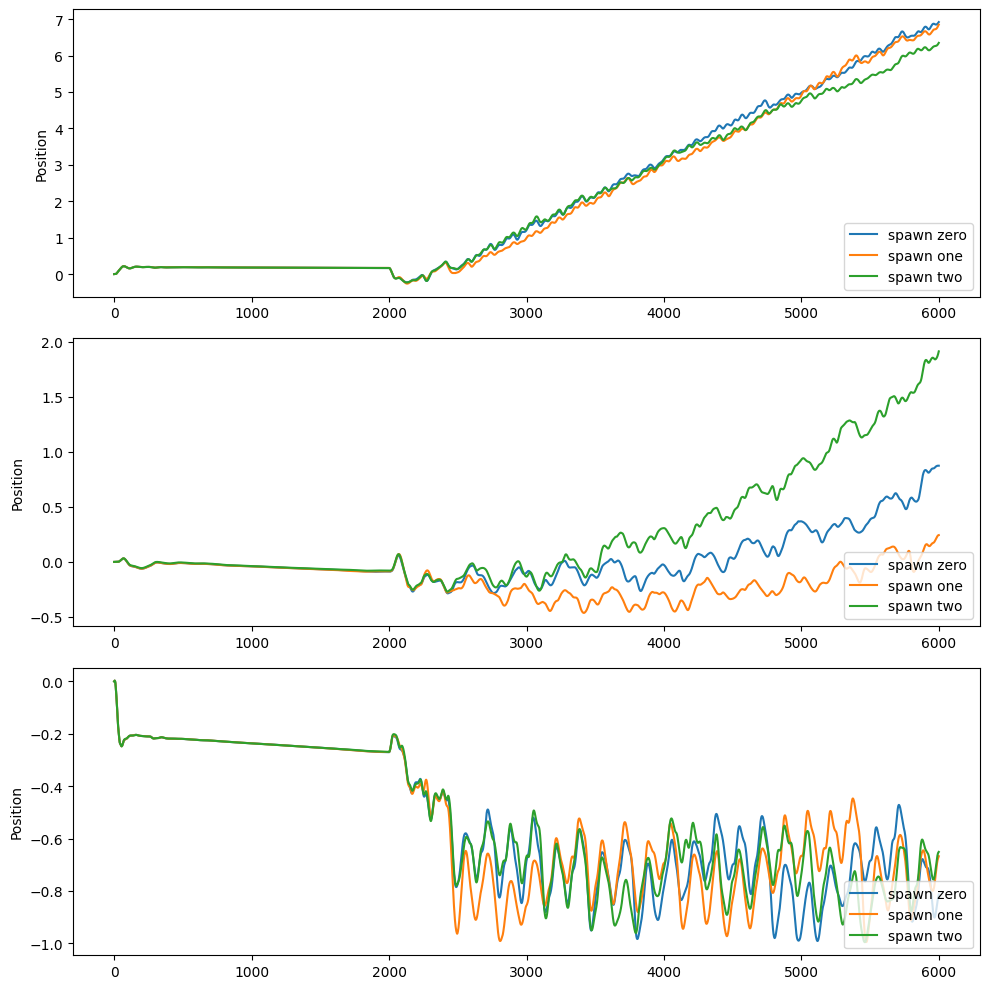

: 

In [35]:
fly_pos_spawn_zero = np.array([obs["fly"][0] for obs in obs_list_spawn_zero])
fly_pos_spawn_one = np.array([obs["fly"][0] for obs in obs_list_spawn_one])
fly_pos_spawn_two = np.array([obs["fly"][0] for obs in obs_list_spawn_two])

if np.all(fly_pos_spawn_zero == fly_pos_spawn_one):
    print("No difference in fly position between spawn zero and spawn one")
if np.all(fly_pos_spawn_zero == fly_pos_spawn_two):
    print("No difference in fly position between spawn zero and spawn two")

fig, axs = plt.subplots(3, 1, figsize=(10, 10))

for i in range(3):
    axs[i].plot(fly_pos_spawn_zero[:, i] - fly_pos_spawn_zero[0, i], label="spawn zero")
    axs[i].plot(fly_pos_spawn_one[:, i] - fly_pos_spawn_one[0, i], label="spawn one")
    axs[i].plot(fly_pos_spawn_two[:, i] - fly_pos_spawn_two[0, i], label="spawn two")
    axs[i].set_ylabel("Position")
    axs[i].legend(loc="lower right")
plt.tight_layout()
plt.show()